## Questions

I assume the affiliation should be for the year when the author published/the editor was an editor? Is that available in MAG?

Difference between `OriginalAffiliation` (in PaperAuthorAffiliations) and `LastKnownAffiliationId` (in Authors)? How would I get `OriginalAffiliation` for editors?

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as so
so.set_theme()
so.set_palette("mako")

In [4]:
"""
affiliation bins
"""
AFF_LABELS = ['1-10', '11-50', '51-100', '101-200', '201-500', '501-1000', '1000+']

In [5]:
def rebin(row):
    if row['rank'].isdigit() and 1 <= int(row['rank']) <= 10:
        val = '1-10'
    elif row['rank'].isdigit() and  11 <= int(row['rank']) <= 50:
        val = '11-50'
    elif row['rank'].isdigit() and  51 <= int(row['rank']) <= 100:
        val = '51-100'
    elif (row['rank'] == '101-150')|(row['rank'] == '151-200'):
        val = '101-200'
    elif (row['rank'] == '201-300')|(row['rank'] == '301-400')|(row['rank'] == '401-500'):
        val = '201-500'
    elif (row['rank'] == '501-600')|(row['rank'] == '601-700')|(row['rank'] == '701-800')|(row['rank'] == '801-900')|(row['rank'] == '901-1000'):
        val = '501-1000'
    elif row['rank'] == '1000+':
        val = '1000+'
    else:
        val = 'other'
    return val

In [26]:
def bucketize_affiliations(author_data, editor_data, tenures, affiliation_rank, bins, labels):
    authors = pd.read_csv(author_data).drop(labels=['Unnamed: 0'], axis=1)
    editors = pd.read_csv(editor_data).drop(labels=['Unnamed: 0'], axis=1)
    tenures = pd.read_csv(tenures, usecols=['Name', 'Role', 'Start', 'End'])
    ranks = pd.read_csv(affiliation_rank).drop(labels=['Unnamed: 0'], axis=1)
    
    editors = editors.merge(tenures, on=['Name'], how='inner')
    
    authors = authors.dropna(subset=['LastKnownAffiliationId'])
    editors = editors.dropna(subset=['LastKnownAffiliationId'])
    
    author_bins = authors.join(ranks.set_index('AffID'), on='LastKnownAffiliationId', how='left', rsuffix='_bin')
    editor_bins = editors.join(ranks.set_index('AffID'), on='LastKnownAffiliationId', how='left', rsuffix='_bin')
    
    author_bins['Bucket'] = pd.cut(x = author_bins['Year'], bins = bins, labels = labels, include_lowest = True)
    editor_bins['Bucket'] = pd.cut(x = editor_bins['Start'], bins = bins, labels = labels, include_lowest = True)
    
    author_bins = author_bins.fillna(value={"rank":"1000+"})
    editor_bins = editor_bins.fillna(value={"rank":"1000+"})
    author_bins['newBins'] = author_bins.apply(rebin, axis=1)
    editor_bins['newBins'] = editor_bins.apply(rebin, axis=1)
    
    author_aff = author_bins.groupby(['Bucket'])
    editor_aff = editor_bins.groupby(['Bucket'])
    
    author_res = author_aff['newBins'].value_counts(normalize=True).to_frame().reset_index(level=[0,1])
    editor_res = editor_aff['newBins'].value_counts(normalize=True).to_frame().reset_index(level=[0,1])
    author_res['newBins'] = pd.Categorical(author_res['newBins'], AFF_LABELS)
    editor_res['newBins'] = pd.Categorical(editor_res['newBins'], AFF_LABELS)
    
    author_res = author_res.sort_values(by=['Bucket', 'newBins'])
    editor_res = editor_res.sort_values(by=['Bucket', 'newBins'])
    
    return author_res, editor_res

In [43]:
def call_bucketize_affiliations(journal):
    author_data = f"../author_data/cleaned/{journal}_authors_cleaned.csv"
    editor_data = f"./../mag_processed/random_duplicates/{journal}_random_duplicates.csv"
    tenures = f"./../editor_data/analysis/tenures/{journal}.tenures.csv"
    affiliations = f"./../normaffil_topuniversities_ranking_2019.csv"
    
    std_bins = [1994, 1998, 2003, 2008, 2013, 2018, 2023]
    std_labels = ['1994-1998', '1999-2003', '2004-2008', '2009-2013', '2014-2018', '2018-2023']
    
    eco_bins = [2007, 2011, 2016, 2021, 2023]
    eco_labels = ['2007-2011', '2012-2016', '2017-2021', '2022-2023']

    jpe_bins = [2017, 2021, 2023]
    jpe_labels = ['2017-2021', '2022-2023']
#     jpe_bins = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
#     jpe_labels = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']
    
    if journal == "eco":
        a, e = bucketize_affiliations(author_data, editor_data, tenures, affiliations, eco_bins, eco_labels)
        return a, e, eco_labels
    elif journal == "jpe":
        a, e = bucketize_affiliations(author_data, editor_data, tenures, affiliations, jpe_bins, jpe_labels)
        return a, e, jpe_labels
    else:
        a, e = bucketize_affiliations(author_data, editor_data, tenures, affiliations, std_bins, std_labels)
        return a, e, std_labels

In [44]:
aer_authors, aer_editors, aer_labels = call_bucketize_affiliations("aer")
eco_authors, eco_editors, eco_labels = call_bucketize_affiliations("eco")
jpe_authors, jpe_editors, jpe_labels = call_bucketize_affiliations("jpe")
qje_authors, qje_editors, qje_labels = call_bucketize_affiliations("qje")
res_authors, res_editors, res_labels = call_bucketize_affiliations("res")

In [61]:
def plot_affiliations(author, editor, journal, year_labels):
    
    author_data = []
    editor_data = []
    for label in AFF_LABELS:
        tmp_author = author[author['newBins'] == label].reset_index(drop=True)['proportion'].to_numpy()
        tmp_editor = editor[editor['newBins'] == label].reset_index(drop=True)['proportion'].to_numpy()
        if len(tmp_author) == 0:
            tmp_author = [0 for _ in range(len(year_labels))]
        if len(tmp_editor) == 0:
            tmp_editor = [0 for _ in range(len(year_labels))]
        author_data.append(tmp_author)
        editor_data.append(tmp_editor)

    author_plot = np.vstack(author_data)
    editor_plot = np.vstack(editor_data)
    
    plt.stackplot(year_labels, author_plot, labels=AFF_LABELS)
    plt.title(f'Affiliation Rankings of Authors at {journal.upper()}')
    plt.legend(bbox_to_anchor=(1,0.5) , loc='lower left')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()
    
    plt.stackplot(year_labels, editor_plot, labels=AFF_LABELS)
    plt.title(f'Affiliation Rankings of Editors at {journal.upper()}')
    plt.legend(bbox_to_anchor=(1,0.5) , loc='lower left')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()

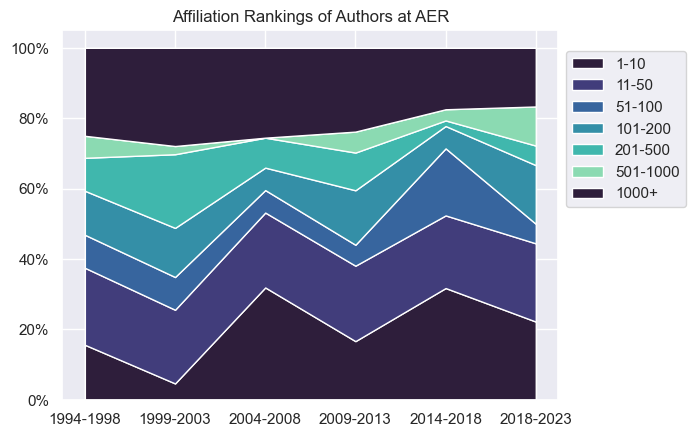

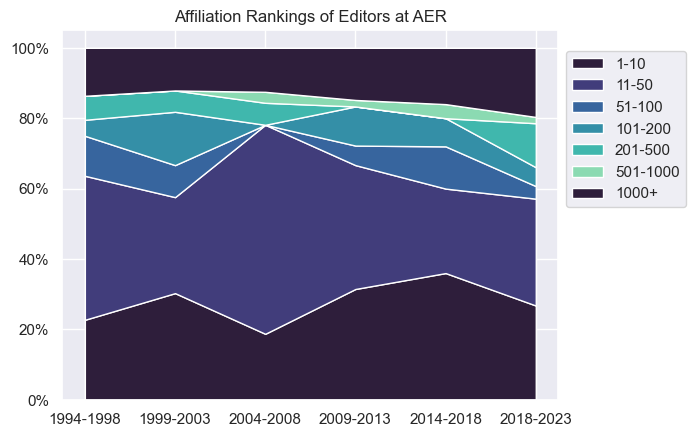

In [62]:
plot_affiliations(aer_authors, aer_editors, "aer", aer_labels)

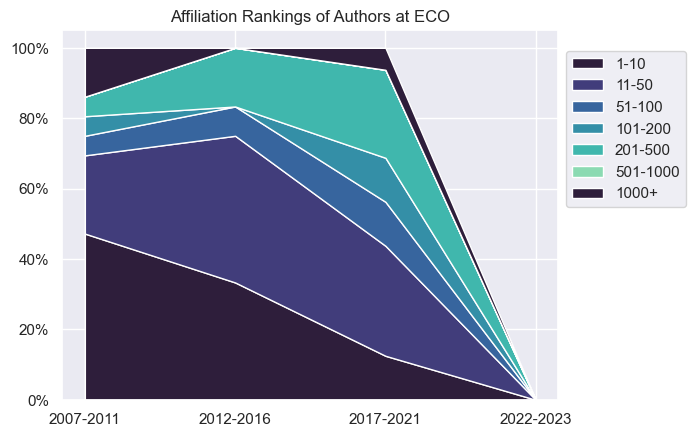

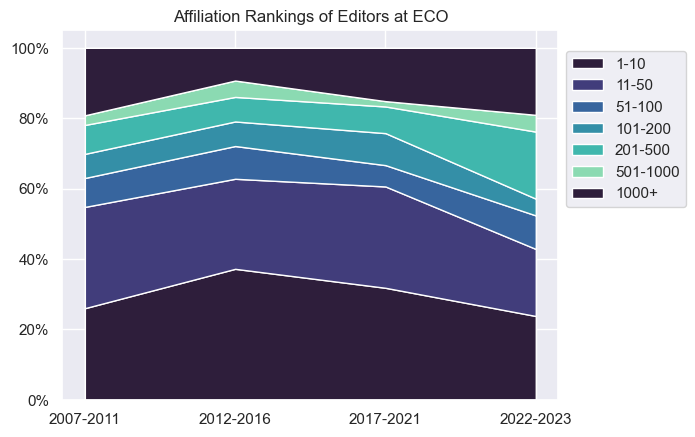

In [63]:
plot_affiliations(eco_authors, eco_editors, "eco", eco_labels)

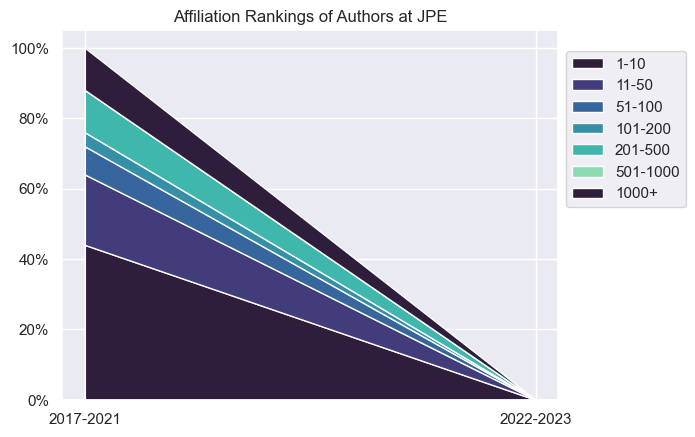

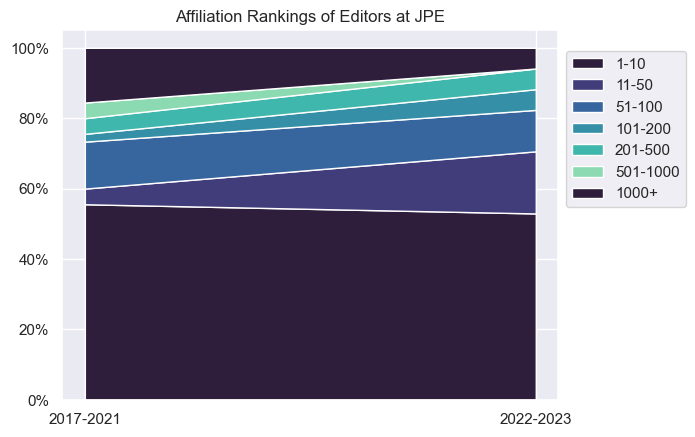

In [64]:
plot_affiliations(jpe_authors, jpe_editors, "jpe", jpe_labels)

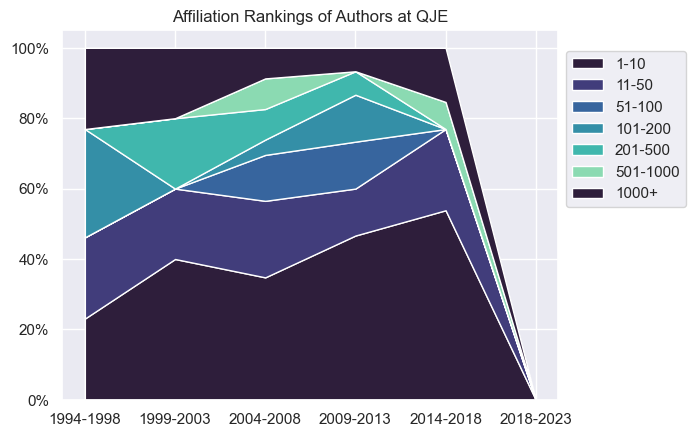

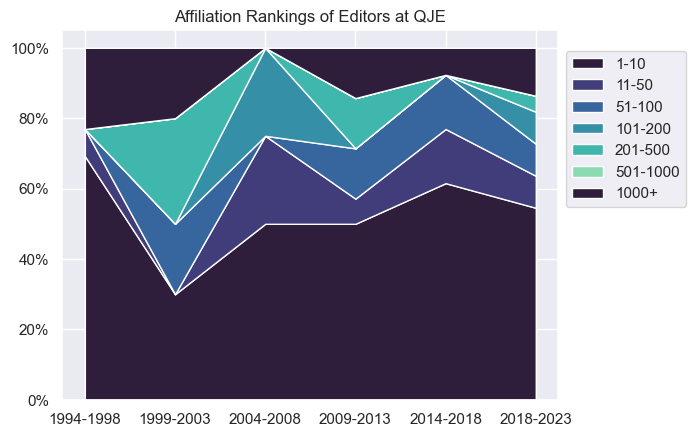

In [65]:
plot_affiliations(qje_authors, qje_editors, "qje", qje_labels)

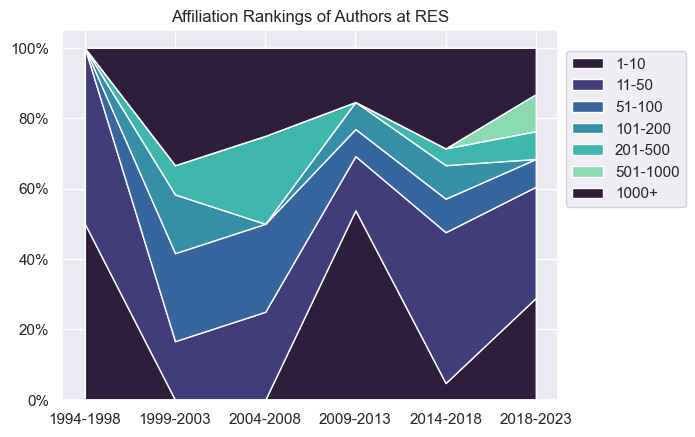

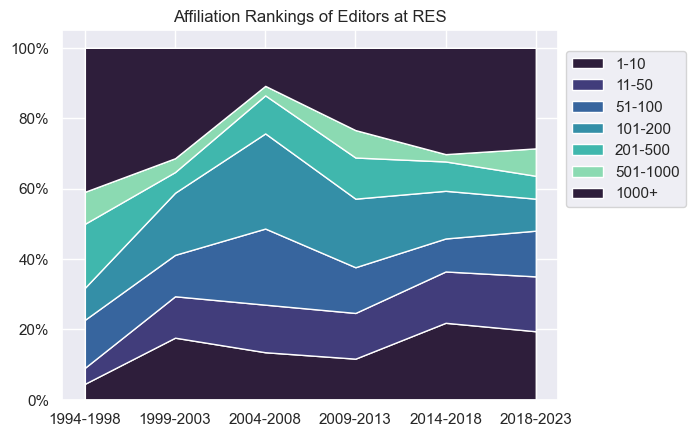

In [66]:
plot_affiliations(res_authors, res_editors, "res", res_labels)